# Inclusion Stress Field Prediction

Импортируем библиотеки:

In [1]:
import os
import glob

import cv2

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms, models

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
torch.manual_seed(42)
cudnn.deterministic = True
cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Обозначим константы:

In [2]:
#Model Constants
IMAGE_SIZE = 256
BATCH_SIZE = 5
LEARNING_RATE = 1e-3
EPOCH = 100
COMPONENTS = ['s11', 's12', 's22', 'e11', 'e12', 'e22']

Основные пути к папкам, откуда мы будем брать исходные данные для данного проекта:

In [3]:
path_folder = 'S:/abaqus_job_files/plot\\'
path_table = 'S:/abaqus_job_files/stresses_data/general_array.csv'

## Работа с табличными данными

In [4]:
def data_preparation(path, path_csv):
    
    stress_components = COMPONENTS + ['geom']
    
    #read data
    df = pd.read_csv(path_csv, delimiter=' ', header=0).round(2)
    df.index += 1
    
    for i in stress_components:

        raw_images = sorted(glob.glob(path + '/*' + i + '*'), key=len)
        df['images_' + i] = raw_images
    
    df = df.dropna(axis=1)
    df_train, df_valid = train_test_split(df,
                                          train_size=.75,
                                          random_state=42,
                                          shuffle=True)
    
    print(f'Train shape: {df_train.shape[0]}')
    print(f'Valid shape: {df_valid.shape[0]}')
        
    return df_train, df_valid

Разделим данные на тренировочную, валидационную и тестовую выборки.

In [5]:
df_train, df_valid = data_preparation(path_folder, path_table)

Train shape: 750
Valid shape: 250


In [6]:
df_train.head()

,max_s11,min_s11,max_s22,min_s22,max_s12,min_s12,max_e11,min_e11,max_e22,min_e22,max_e12,min_e12,images_s11,images_s12,images_s22,images_e11,images_e12,images_e22,images_geom
83,148.84,69.78,157.39,70.29,27.35,-32.86,1.14,0.01,1.22,0.02,0.80,-0.97,S:/abaqus_job_files/plot\83_s11.png,S:/abaqus_job_files/plot\83_s12.png,S:/abaqus_job_files/plot\83_s22.png,S:/abaqus_job_files/plot\83_e11.png,S:/abaqus_job_files/plot\83_e12.png,S:/abaqus_job_files/plot\83_e22.png,S:/abaqus_job_files/plot\83_geom.png
992,146.91,72.48,171.91,71.97,38.61,-30.13,0.92,0.05,1.15,0.07,1.14,-0.89,S:/abaqus_job_files/plot\992_s11.png,S:/abaqus_job_files/plot\992_s12.png,S:/abaqus_job_files/plot\992_s22.png,S:/abaqus_job_files/plot\992_e11.png,S:/abaqus_job_files/plot\992_e12.png,S:/abaqus_job_files/plot\992_e22.png,S:/abaqus_job_files/plot\992_geom.png
790,199.29,68.72,152.10,70.04,36.38,-32.88,1.48,0.04,1.16,0.04,1.05,-0.97,S:/abaqus_job_files/plot\790_s11.png,S:/abaqus_job_files/plot\790_s12.png,S:/abaqus_job_files/plot\790_s22.png,S:/abaqus_job_files/plot\790_e11.png,S:/abaqus_job_files/plot\790_e12.png,S:/abaqus_job_files/plot\790_e22.png,S:/abaqus_job_files/plot\790_geom.png
895,141.63,70.42,178.51,68.98,29.22,-40.71,0.95,0.00,1.39,0.07,0.86,-1.20,S:/abaqus_job_files/plot\895_s11.png,S:/abaqus_job_files/plot\895_s12.png,S:/abaqus_job_files/plot\895_s22.png,S:/abaqus_job_files/plot\895_e11.png,S:/abaqus_job_files/plot\895_e12.png,S:/abaqus_job_files/plot\895_e22.png,S:/abaqus_job_files/plot\895_geom.png
399,153.94,69.03,198.59,67.67,41.09,-32.87,0.95,0.05,1.49,0.06,1.21,-0.86,S:/abaqus_job_files/plot\399_s11.png,S:/abaqus_job_files/plot\399_s12.png,S:/abaqus_job_files/plot\399_s22.png,S:/abaqus_job_files/plot\399_e11.png,S:/abaqus_job_files/plot\399_e12.png,S:/abaqus_job_files/plot\399_e22.png,S:/abaqus_job_files/plot\399_geom.png


## EDA

Оценим распределение представленных величин.

In [7]:
def kde_plot(data_list, columns, variable_name):
    
    fig, ax = plt.subplots(2, 3, figsize=(13, 9))
    
    for data in data_list:
        for column, i, j in zip(columns, [0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]):
            
            sns.kdeplot(x=column,
                        data=data,
                        shade=True,
                        ax=ax[i, j])
            
            if j == 0:
                ax[i, j].set_ylabel('Density', fontsize=12)
            else:
                ax[i, j].set_ylabel('')
                
            ax[i, j].set_xlabel(f'{column}')
            ax[i, j].set_title(f'KDE of {column}')
            ax[i, j].legend(['Train', 'Valid', 'Test'])
    
    fig.suptitle(f'Kernel density estimation of presented {variable_name} variables', fontsize=18)
    fig.tight_layout()
    plt.show()

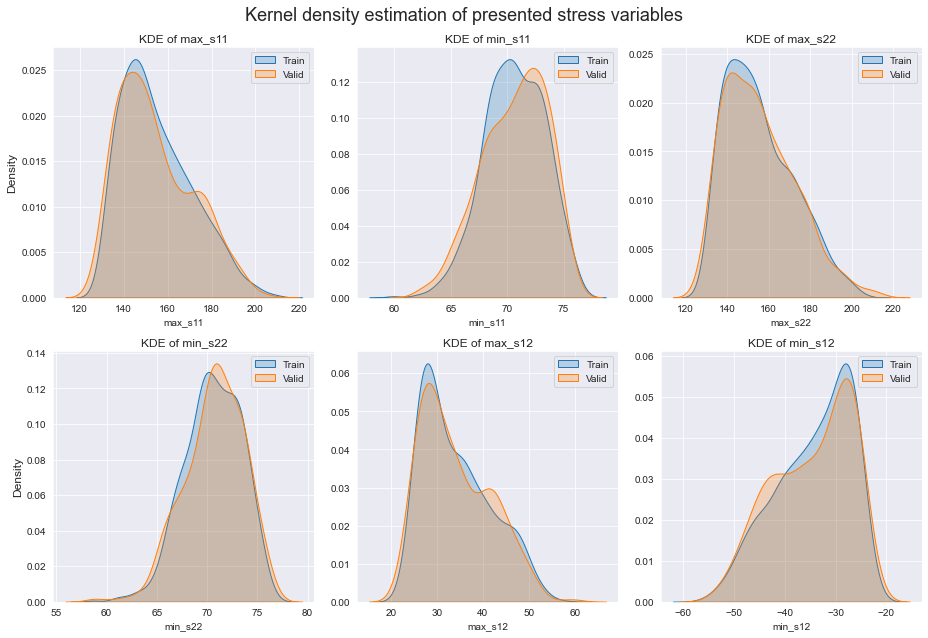

In [8]:
kde_plot([df_train, df_valid],
         ['max_s11', 'min_s11','max_s22', 'min_s22','max_s12', 'min_s12'],
         'stress')

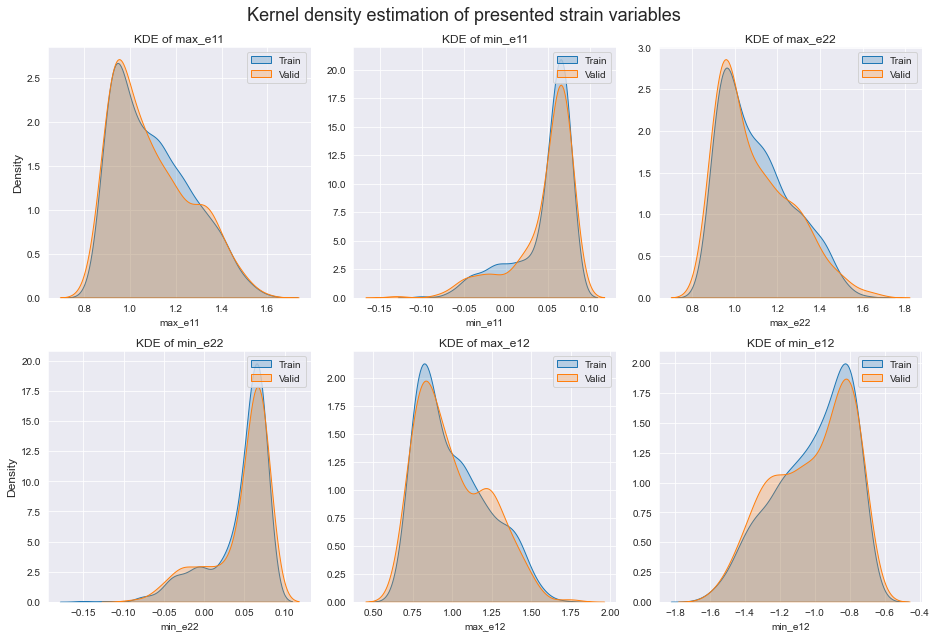

In [9]:
kde_plot([df_train, df_valid],
         ['max_e11', 'min_e11','max_e22', 'min_e22','max_e12', 'min_e12'],
         'strain')

Распределения всех представленных величин крайне схожи по своей форме для различных наборов данных - тренировочного, валидационного и тестового датасетов.

## Загрузчик данных

Напишем загрузчик данных, который сможет выгружать датасеты по отдельным компонентам.

In [10]:
class Stress_Strain_dataset(torch.utils.data.Dataset):
    '''Forming dataset of Stress-Strain components, which inludes image prepocessing.'''
    
    def __init__(self, df, transform=False):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        #geometry preprocessing
        geometry = cv2.imread(self.df.iloc[index, -1], cv2.IMREAD_GRAYSCALE)
        #crop
        geometry = geometry[20:780, 331:1092]
        #resize
        geometry = cv2.resize(geometry, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normalize
        #geometry = (255 - geometry)
        geometry = cv2.threshold(geometry, 127, 255, cv2.THRESH_BINARY)[1]
        geometry = geometry / 255
        #add additional dimension
        geometry = np.array([geometry])
        #convert to torch.Tensor
        geometry = torch.from_numpy(geometry.copy()).type(torch.float32)
        
        list_output = np.zeros((geometry.shape))
        
        for component in COMPONENTS:
            
            columns_mask = [component in column for column in self.df.columns]
            columns = self.df.columns[columns_mask]

            self.df_local = self.df[columns]
        
            result = cv2.imread(self.df_local.iloc[index, -1], cv2.IMREAD_GRAYSCALE)
            #crop
            result = result[118:637, 523:1043]
            #resize image
            result = cv2.resize(result, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
            #normalize between 0 and 1
            result = result / 255

            #normalize between min and max stresses
            result = cv2.normalize(
                result, None, alpha=self.df_local.iloc[index, 1],
                beta=self.df_local.iloc[index, 0], norm_type=cv2.NORM_MINMAX
            )
            result = np.array([result])
            
            if component == COMPONENTS[0]:
                list_output = result
            else:
                list_output = np.concatenate([list_output, result], axis=0)
            
            del result
        
        output = torch.from_numpy(list_output.copy()).type(torch.float32)
        
        return (geometry, output)

Отдельно обработаем каждую из искомых компонет для тензоров $\bf{\sigma}$ и $\bf{\varepsilon}$.

In [11]:
#train datasets
train_dataset = Stress_Strain_dataset(df_train)
#valid datasets
valid_dataset = Stress_Strain_dataset(df_valid)

In [12]:
#train dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               drop_last=True)
#valid dataloader
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               drop_last=True)

In [13]:
def show_images(tensor, number_of_images=3, initial_index=0, cmap='viridis', values_name=None):
    
    tensor = tensor.numpy().transpose(0,2,3,1)
    
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(number_of_images):
        
        fig.add_subplot(1, number_of_images+1, i+1)
    
        plt.imshow(tensor[i+initial_index], cmap=cmap)
        min = (tensor[i+initial_index]).min()
        max = (tensor[i+initial_index]).max()

        plt.clim(min, max)
        plt.colorbar(shrink=0.2)

        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        
        if values_name == None:
            plt.title(f'Min={min} Max={max}')
        else:
            plt.title(f'Min={min:.2f} Max={max:.2f}')

In [14]:
def show_from_loader(dataloader, number_of_images=3, initial_index=0):
    
    masks, images = next(iter(dataloader))
    
    print(masks.shape, images.shape)
    
    show_images(masks, cmap='PuBu')
    
    for i, values_name in zip(range(images.shape[1]), COMPONENTS):
        
        tensor = torch.reshape(images[:, i], masks.shape)
        
        show_images(tensor, values_name=values_name)

torch.Size([5, 1, 256, 256]) torch.Size([5, 6, 256, 256])


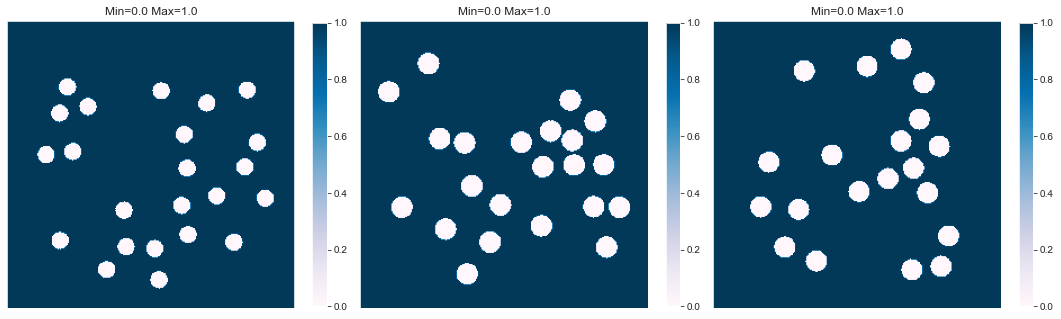

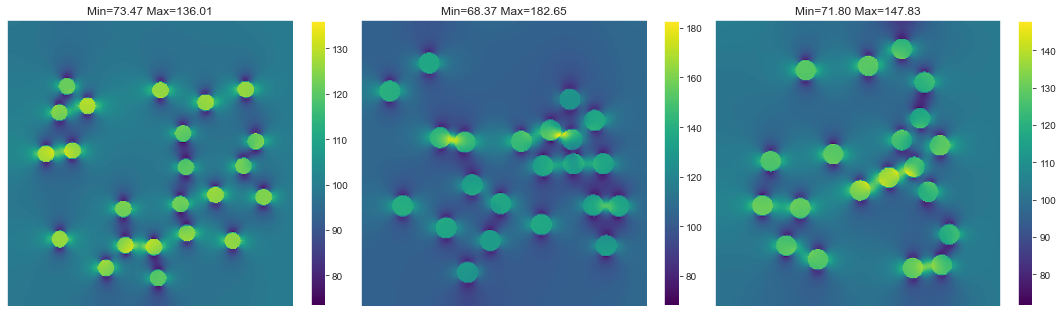

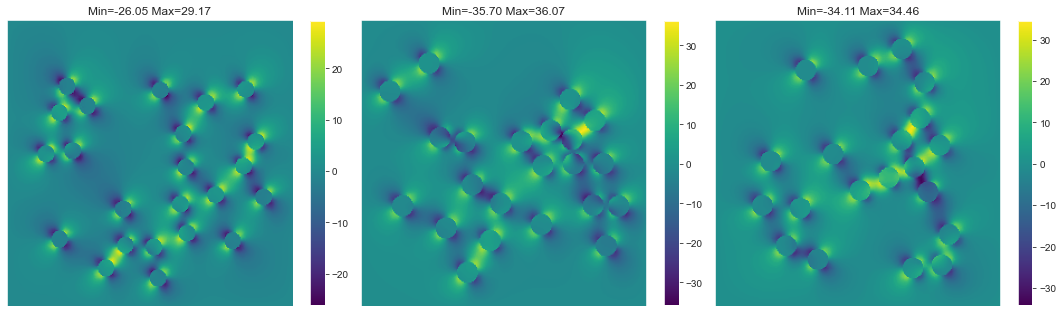

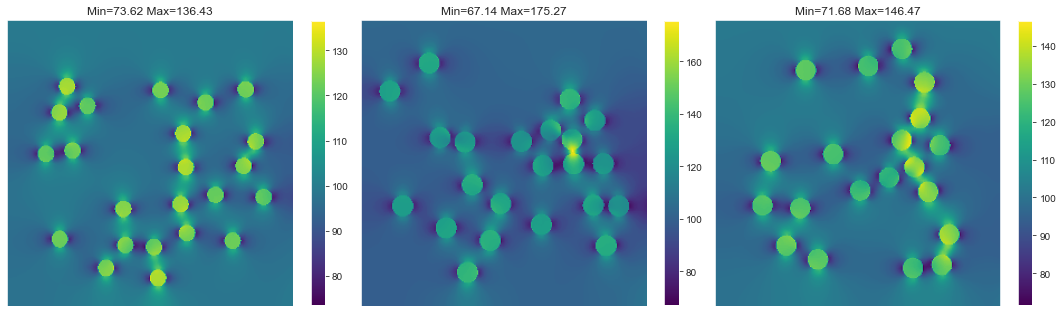

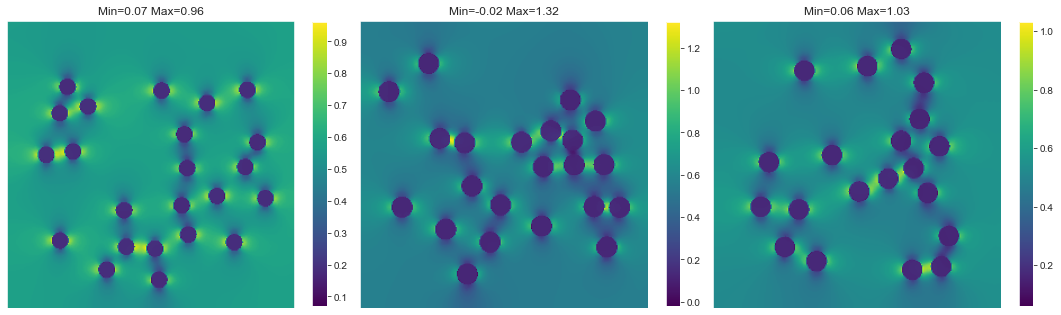

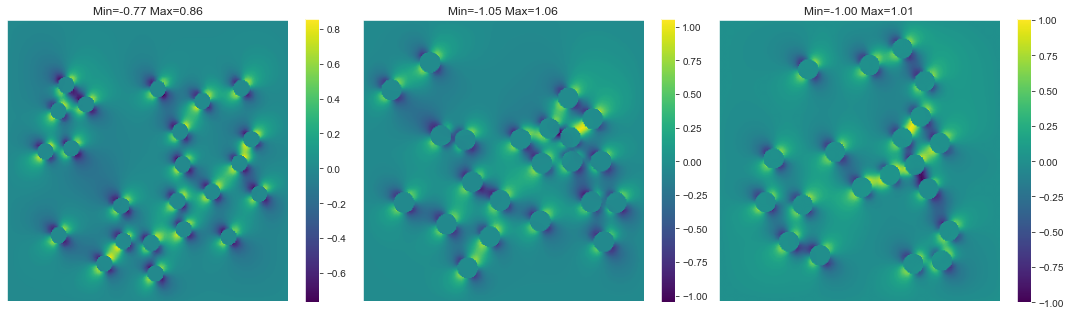

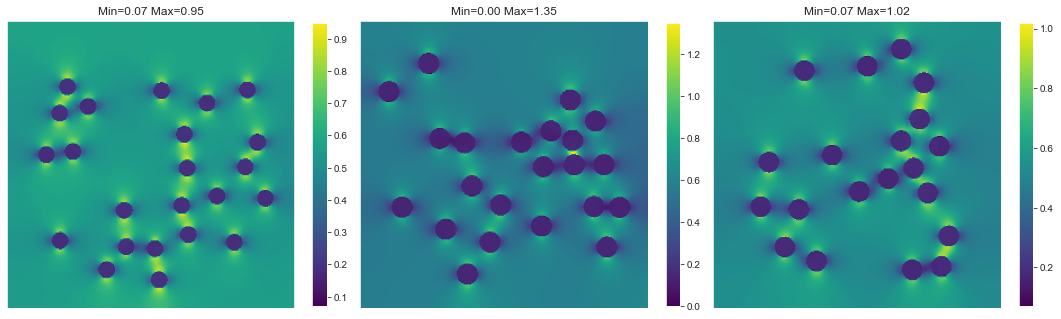

In [15]:
show_from_loader(train_dataloader)

## Модель 

Определим **дискриминатор**.

In [16]:
class Discriminator(nn.Module):
    """Discriminator Network"""
    def __init__(self):
        super(Discriminator, self).__init__()

        self.in_channels = 1
        self.ndf = 64
        self.out_channels = 1

        self.main = nn.Sequential(
            nn.Conv2d(self.in_channels*2, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 128

            nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*2),
            # 64 x 64

            nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*4),
            # 32 x 32

            nn.Conv2d(self.ndf*4, self.ndf*8, 4, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*8),
            # 31 x 31

            nn.Conv2d(self.ndf*8, self.out_channels, 4, 1, 1, bias=False),
            # 30 x 30 (PatchGAN)
            nn.Sigmoid()
        )

    def forward(self, x, label):
        
        out = torch.cat((x, label), dim=1)
        out = self.main(out)
        
        return out

И **генератор**.

In [17]:
class Generator(nn.Module):
    """Generator Network"""
    def __init__(self):
        
        super(Generator, self).__init__()

        self.input_dim = 1
        self.ngf = 64
        self.output_dim = 1

        self.conv1 = nn.Sequential(
            nn.Conv2d(self.input_dim, self.ngf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.ngf, self.ngf*2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(self.ngf*2, self.ngf*4, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*4)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(self.ngf*4, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )
        self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*4, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*4),
            nn.ReLU(inplace=True)
        )
        self.deconv6 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*8, self.ngf*2, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*2),
            nn.ReLU(inplace=True)
        )
        self.deconv7 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*4, self.ngf, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf),
            nn.ReLU(inplace=True)
        )
        self.deconv8 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*2, self.output_dim, 4, 2, 1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)

        dec1 = torch.cat([self.deconv1(enc8), enc7], dim=1)
        dec2 = torch.cat([self.deconv2(dec1), enc6], dim=1)
        dec3 = torch.cat([self.deconv3(dec2), enc5], dim=1)
        dec4 = torch.cat([self.deconv4(dec3), enc4], dim=1)
        dec5 = torch.cat([self.deconv5(dec4), enc3], dim=1)
        dec6 = torch.cat([self.deconv6(dec5), enc2], dim=1)
        dec7 = torch.cat([self.deconv7(dec6), enc1], dim=1)
        out = self.deconv8(dec7)

        return out

In [18]:
def set_requires_grad(network, requires_grad=False):
    """Prevent a Network from Updating"""
    for param in network.parameters():
        param.requires_grad = requires_grad

In [19]:
# stress models
D_s11 = Discriminator()
G_s11 = Generator()

D_s12 = Discriminator()
G_s12 = Generator()

D_s22 = Discriminator()
G_s22 = Generator()
# strain models
D_e11 = Discriminator()
G_e11 = Generator()

D_e12 = Discriminator()
G_e12 = Generator()

D_e22 = Discriminator()
G_e22 = Generator()

Определим **loss**-функцию и **optimizer**.

In [20]:
criterion_Adversarial = nn.BCELoss()
criterion_Pixelwise = nn.L1Loss()

In [21]:
# stress optimizer
D_optim_s11 = torch.optim.Adam(D_s11.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_optim_s11 = torch.optim.Adam(G_s11.parameters(), lr=1e-3, betas=(0.5, 0.999))

D_optim_s12 = torch.optim.Adam(D_s12.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_optim_s12 = torch.optim.Adam(G_s12.parameters(), lr=1e-3, betas=(0.5, 0.999))

D_optim_s22 = torch.optim.Adam(D_s22.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_optim_s22 = torch.optim.Adam(G_s22.parameters(), lr=1e-3, betas=(0.5, 0.999))

# strain optimizer
D_optim_e11 = torch.optim.Adam(D_e11.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_optim_e11 = torch.optim.Adam(G_e11.parameters(), lr=1e-3, betas=(0.5, 0.999))

D_optim_e12 = torch.optim.Adam(D_e12.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_optim_e12 = torch.optim.Adam(G_e12.parameters(), lr=1e-3, betas=(0.5, 0.999))

D_optim_e22 = torch.optim.Adam(D_e22.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_optim_e22 = torch.optim.Adam(G_e22.parameters(), lr=1e-3, betas=(0.5, 0.999))

## Обучение

In [22]:
# stress train loss history
G_train_loss_history_s11, G_train_loss_history_s12, G_train_loss_history_s22 = [], [], []
D_train_loss_history_s11, D_train_loss_history_s12, D_train_loss_history_s22 = [], [], []

# strain train loss history
G_train_loss_history_e11, G_train_loss_history_e12, G_train_loss_history_e22 = [], [], []
D_train_loss_history_e11, D_train_loss_history_e12, D_train_loss_history_e22 = [], [], []

# stress valid loss history
G_valid_loss_history_s11, G_valid_loss_history_s12, G_valid_loss_history_s22 = [], [], []
D_valid_loss_history_s11, D_valid_loss_history_s12, D_valid_loss_history_s22 = [], [], []

# strain valid loss history
G_valid_loss_history_e11, G_valid_loss_history_e12, G_valid_loss_history_e22 = [], [], []
D_valid_loss_history_e11, D_valid_loss_history_e12, D_valid_loss_history_e22 = [], [], []

Зададим списки, содержащие все необходимые эелементы для каждой модели.

In [23]:
G_list = [G_s11, G_s12, G_s22,
          G_e11, G_e12, G_e22]
D_list = [D_s11, D_s12, D_s22,
          D_e11, D_e12, D_e22]

G_optim_list = [G_optim_s11, G_optim_s12, G_optim_s22,
                G_optim_e11, G_optim_e12, G_optim_e22]
D_optim_list = [D_optim_s11, D_optim_s12, D_optim_s22,
                D_optim_e11, D_optim_e12, D_optim_e22]

G_train_loss_list = [G_train_loss_history_s11, G_train_loss_history_s12, G_train_loss_history_s22,
                     G_train_loss_history_e11, G_train_loss_history_e12, G_train_loss_history_e22]
D_train_loss_list = [D_train_loss_history_s11, D_train_loss_history_s12, D_train_loss_history_s22,
                     D_train_loss_history_e11, D_train_loss_history_e12, D_train_loss_history_e22]

G_valid_loss_list = [G_valid_loss_history_s11, G_valid_loss_history_s12, G_valid_loss_history_s22,
                     G_valid_loss_history_e11, G_valid_loss_history_e12, G_valid_loss_history_e22]
D_valid_loss_list = [D_valid_loss_history_s11, D_valid_loss_history_s12, D_valid_loss_history_s22,
                     D_valid_loss_history_e11, D_valid_loss_history_e12, D_valid_loss_history_e22]

layer_list = list(range(len(COMPONENTS)))

In [24]:
for epoch in range(EPOCH + 1):
    
    for G, D, G_optim, D_optim, G_train_loss_history, D_train_loss_history, G_valid_loss_history, D_valid_loss_history, i, component in zip(
        G_list, D_list, G_optim_list,
        D_optim_list, G_train_loss_list, D_train_loss_list,
        G_valid_loss_list, D_valid_loss_list, layer_list,
        COMPONENTS
    ):
    
        # train
        G.train()
        D.train()
        
        G = G.to(device)
        D = D.to(device)
        
        for geometry, result in train_dataloader:

            D_optim.zero_grad()
            G_optim.zero_grad()

            geometry = geometry.to(device, dtype=torch.float)
            result = result[:, i].to(device, dtype=torch.float)
            result = torch.reshape(result, geometry.shape)

            set_requires_grad(D, requires_grad=False)

            # Train Generator
            fake_result = G(geometry)
            prob_fake = D(fake_result, geometry)
            real_labels = torch.ones(prob_fake.size()).to(device)
            G_loss_fake = criterion_Adversarial(prob_fake, real_labels)

            G_loss_pixelwise = criterion_Pixelwise(fake_result, result)

            G_loss = G_loss_fake + G_loss_pixelwise
            G_train_loss_history.append(G_loss.item())

            G_loss.backward()
            G_optim.step()

            # Train Discriminator
            set_requires_grad(D, requires_grad=True)

            prob_real = D(result, geometry)
            real_labels = torch.ones(prob_real.size()).to(device)
            D_real_loss = criterion_Adversarial(prob_real, real_labels)

            fake_result = G(geometry)
            prob_fake = D(fake_result.detach(), geometry)
            fake_labels = torch.zeros(prob_fake.size()).to(device)
            D_fake_loss = criterion_Adversarial(prob_fake, fake_labels)

            D_loss = torch.mean(D_real_loss + D_fake_loss)
            D_train_loss_history.append(D_loss.item())

            D_loss.backward()
            D_optim.step()

            del geometry, result, fake_labels, real_labels
            torch.cuda.empty_cache()
        
        G.eval()
        D.eval()
        
        for geometry, result in valid_dataloader:

            geometry = geometry.to(device, dtype=torch.float)
            result = result[:, i].to(device, dtype=torch.float)
            result = torch.reshape(result, geometry.shape)
            
            fake_result = G(geometry)
            prob_fake = D(fake_result, geometry)
            real_labels = torch.ones(prob_fake.size()).to(device)
            G_loss_fake = criterion_Adversarial(prob_fake, real_labels)

            G_loss_pixelwise = criterion_Pixelwise(fake_result, result)

            G_loss = G_loss_fake + G_loss_pixelwise
            G_valid_loss_history.append(G_loss.item())

            prob_real = D(result, geometry)
            real_labels = torch.ones(prob_real.size()).to(device)
            D_real_loss = criterion_Adversarial(prob_real, real_labels)

            fake_result = G(geometry)
            prob_fake = D(fake_result.detach(), geometry)
            fake_labels = torch.zeros(prob_fake.size()).to(device)
            D_fake_loss = criterion_Adversarial(prob_fake, fake_labels)

            D_loss = torch.mean(D_real_loss + D_fake_loss)
            D_valid_loss_history.append(D_loss.item())
            
            del geometry, result, fake_labels, real_labels
            torch.cuda.empty_cache()
        
        G = G.cpu()
        D = D.cpu()

        G_train_loss = np.mean(G_train_loss_history)
        D_train_loss = np.mean(D_train_loss_history)
        
        G_valid_loss = np.mean(G_valid_loss_history)
        D_valid_loss = np.mean(D_valid_loss_history)

        print(
            f'{epoch} | {component} | D Train:{D_train_loss:.4f} | G Train:{G_train_loss:.4f} | D Valid:{D_valid_loss:.4f} | G Valid:{G_valid_loss:.4f}'
        )

KeyboardInterrupt: 

## Результаты 

Отдельно сохраним результаты обучения модели.

In [ ]:
dict_data = {'G train loss s11' : G_train_loss_history_s11,
             'G train loss s12' : G_train_loss_history_s12,
             'G train loss s22' : G_train_loss_history_s22,
             'G train loss e11' : G_train_loss_history_e11,
             'G train loss e12' : G_train_loss_history_e12,
             'G train loss e22' : G_train_loss_history_e22,
             'D train loss s11' : D_train_loss_history_s11,
             'D train loss s12' : D_train_loss_history_s12,
             'D train loss s22' : D_train_loss_history_s22,
             'D train loss e11' : D_train_loss_history_e11,
             'D train loss e12' : D_train_loss_history_e12,
             'D train loss e22' : D_train_loss_history_e22,
             'G valid loss s11' : G_valid_loss_history_s11,
             'G valid loss s12' : G_valid_loss_history_s12,
             'G valid loss s22' : G_valid_loss_history_s22,
             'G valid loss e11' : G_valid_loss_history_e11,
             'G valid loss e12' : G_valid_loss_history_e12,
             'G valid loss e22' : G_valid_loss_history_e22,
             'D valid loss s11' : D_valid_loss_history_s11,
             'D valid loss s12' : D_valid_loss_history_s12,
             'D valid loss s22' : D_valid_loss_history_s22,
             'D valid loss e11' : D_valid_loss_history_e11,
             'D valid loss e12' : D_valid_loss_history_e12,
             'D valid loss e22' : D_valid_loss_history_e22}

In [ ]:
df_results = pd.DataFrame.from_dict(dict_data)
df_results.to_csv('S:/abaqus_job_files/results_data/loss_results.csv', sep=' ')

Визуально оценим результаты работы алгоритма.

In [ ]:
def singular_result(dataloader, model=G_s11, initial_index=0, cmap='viridis', component='$\sigma_{11}$', index=0):
    
    model.eval()
    model = model.cpu()
    geometry, result_set = next(iter(dataloader))
    result = torch.reshape(result_set[:, index], geometry.shape)

    prediction = model(geometry.float())
    #prediction = prediction_set[0]
    error = abs(result - prediction)

    tensors = [geometry, result, prediction, error]
    titles = ['Geometry', f'True {component} field', f'Predicted {component} field', '$L_{1}$ error']
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    for tensor, title, i, j in zip(tensors, titles, [0, 0, 1, 1], [0, 1, 0, 1]): 
        
        tensor = tensor.cpu().detach().numpy().transpose(0,2,3,1)
        
        if i == 0 and j == 0:
            img = ax[i, j].imshow(tensor[initial_index], cmap='PuBu')
        elif i != j:
            img = ax[i, j].imshow(tensor[initial_index], cmap=cmap)
        else:
            img = ax[i, j].imshow(tensor[initial_index], cmap='icefire')
            
        ax[i, j].set_title(title, fontsize=14)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
        min = (tensor[initial_index]).min()
        max = (tensor[initial_index]).max()
        
        if i == 1 and j == 1:
            img.set_clim(0, max)
        else:
            img.set_clim(min, max)
            
        plt.colorbar(img, shrink=0.815, ax=ax[i, j])
            
    fig.suptitle(f'Visualization for the one sample of {component}', fontsize=18)
    fig.tight_layout()
    plt.show()

In [ ]:
singular_result(test_dataloader)